In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
print("=" * 80)
print("1. CARGA DE DATOS")
print("=" * 80)

df = pd.read_csv('../datos/Food_Delivery_Times.csv')

print(f"\nDimensiones del dataset: {df.shape[0]} filas x {df.shape[1]} columnas")
print("\nPrimeras 5 filas:")
print(df.head())

1. CARGA DE DATOS

Dimensiones del dataset: 1000 filas x 9 columnas

Primeras 5 filas:
   Order_ID  Distance_km Weather Traffic_Level Time_of_Day Vehicle_Type  \
0       522         7.93   Windy           Low   Afternoon      Scooter   
1       738        16.42   Clear        Medium     Evening         Bike   
2       741         9.52   Foggy           Low       Night      Scooter   
3       661         7.44   Rainy        Medium   Afternoon      Scooter   
4       412        19.03   Clear           Low     Morning         Bike   

   Preparation_Time_min  Courier_Experience_yrs  Delivery_Time_min  
0                    12                     1.0                 43  
1                    20                     2.0                 84  
2                    28                     1.0                 59  
3                     5                     1.0                 37  
4                    16                     5.0                 68  


In [4]:
# 1. Eliminar duplicados
df.drop_duplicates(inplace=True)

# 2. Rellenar o eliminar datos faltantes
# Ejemplo: rellenar valores numéricos con la mediana
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Rellenar valores categóricos con el modo
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# 3. Detección y eliminación de outliers (usando IQR)
num_cols = df.select_dtypes(include=[np.number]).columns

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]

print(df.shape)


(994, 9)


In [5]:
# Identificar columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns
print("Columnas categóricas:", list(cat_cols))

# Opción 1: Label Encoding (para variables con orden o pocas categorías)
le = LabelEncoder()
for col in cat_cols:
    if df[col].nunique() <= 5:  # puedes ajustar este umbral
        df[col] = le.fit_transform(df[col])
    else:
        # Opción 2: One-Hot Encoding (para variables sin orden y con varias categorías)
        dummies = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
df.head()

Columnas categóricas: ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,4,1,0,2,12,1.0,43
1,738,16.42,0,2,1,0,20,2.0,84
2,741,9.52,1,1,3,2,28,1.0,59
3,661,7.44,2,2,0,2,5,1.0,37
4,412,19.03,0,1,2,0,16,5.0,68


In [6]:
# Seleccionar columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Escalador
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
print("\n✅ Normalización completada.")
df.head()


✅ Normalización completada.


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,0.075837,-0.367188,2.031759,-0.296387,-1.277600,1.374569,-0.688605,-1.250681,-0.623719
1,0.823324,1.127042,-0.855401,1.030679,-0.232386,-0.912162,0.422102,-0.902842,1.304302
2,0.833706,-0.087350,-0.133611,-0.296387,1.858040,1.374569,1.532810,-1.250681,0.128680
3,0.556859,-0.453427,0.588179,1.030679,-1.277600,1.374569,-1.660475,-1.250681,-0.905868
4,-0.304828,1.586399,-0.855401,-0.296387,0.812827,-0.912162,-0.133251,0.140675,0.551904


Distance_km               0.670725
Preparation_Time_min      0.145538
Order_ID                  0.072871
Traffic_Level             0.031752
Courier_Experience_yrs    0.030858
Weather                   0.021306
Time_of_Day               0.017144
Vehicle_Type              0.009805
dtype: float64


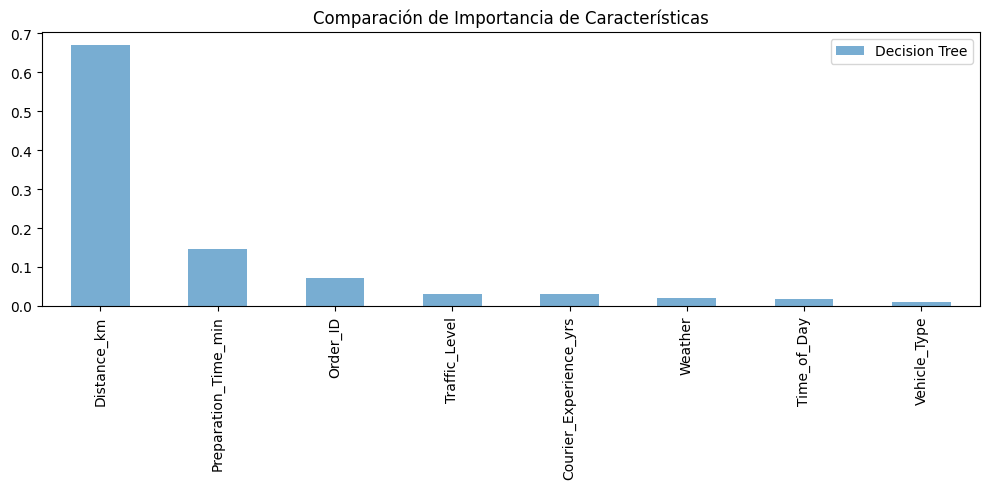

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

target = 'Delivery_Time_min'
if target not in df.columns:
    print(f"No existe esta variable")
else:
    X = df.drop(target, axis=1)
    y = df[target]

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Árbol de Decisión
    tree = DecisionTreeRegressor(random_state=42)
    tree.fit(X_train, y_train)

    importances_tree = pd.Series(tree.feature_importances_, index=X.columns)
    print(importances_tree.sort_values(ascending=False))

    #Visualizacion comparativa
    plt.figure(figsize=(10,5))
    importances_tree.sort_values(ascending=False).plot(kind='bar', alpha=0.6, label='Decision Tree')
    plt.title("Comparación de Importancia de Características")
    plt.legend()
    plt.tight_layout()
    plt.show()
